## Process High Frequency Data:

This notebook depends on the output of earthscope-mt-course/notebooks/mth5/07_make_mth5_from_phoenix.ipynb
It is based on an older HF processing Zen notebook.

A Phoenix file can be found in  data/time_series/zen/mth5_from_phoenix.h5


In [1]:
# Required imports for the program. 
import numpy as np
from pathlib import Path
import pandas as pd
import warnings

from mth5.clients.make_mth5 import MakeMTH5
from mth5 import mth5, timeseries
from mth5.utils.helpers import initialize_mth5
from mt_metadata.utils.mttime import get_now_utc, MTime
from aurora.config import BANDS_DEFAULT_FILE
from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.process_mth5 import process_mth5
from mtpy.processing import KernelDataset, RunSummary

warnings.filterwarnings('ignore')

/home/kkappler/software/irismt/mtpy-v2/mtpy/modeling/simpeg/recipes/inversion_2d.py:39: UserWarning: Pardiso not installed see https://github.com/simpeg/pydiso/blob/main/README.md.
  warnings.warn(


## Set up the path to the file

In [2]:
here = Path(".")
data_dir = here.joinpath("../../data/time_series/phoenix")
mth5_path = data_dir.joinpath("mth5_from_phoenix.h5")

mth5_path.exists()

True

In [20]:
from mth5.mth5 import MTH5
m = MTH5()
m.open_mth5(mth5_path)

/:
    |- Group: Experiment
    --------------------
        |- Group: Reports
        -----------------
        |- Group: Standards
        -------------------
            --> Dataset: summary
            ......................
        |- Group: Surveys
        -----------------
            |- Group: MIST
            --------------
                |- Group: Filters
                -----------------
                    |- Group: coefficient
                    ---------------------
                        |- Group: dipole_58m
                        --------------------
                        |- Group: v_to_mv
                        -----------------
                    |- Group: fap
                    -------------
                    |- Group: fir
                    -------------
                    |- Group: time_delay
                    --------------------
                    |- Group: zpk
                    -------------
                |- Group: Reports
                ---

In [3]:
mth5_object = initialize_mth5(mth5_path)

In [23]:
survey = m.get_survey("MIST")

In [24]:
survey

/Experiment/Surveys/MIST:
    |- Group: Filters
    -----------------
        |- Group: coefficient
        ---------------------
            |- Group: dipole_58m
            --------------------
            |- Group: v_to_mv
            -----------------
        |- Group: fap
        -------------
        |- Group: fir
        -------------
        |- Group: time_delay
        --------------------
        |- Group: zpk
        -------------
    |- Group: Reports
    -----------------
    |- Group: Standards
    -------------------
        --> Dataset: summary
        ......................
    |- Group: Stations
    ------------------
        |- Group: 9042
        --------------
            |- Group: Fourier_Coefficients
            ------------------------------
            |- Group: Transfer_Functions
            ----------------------------
            |- Group: sr150_0001
            --------------------
                --> Dataset: e1
                .................
          

In [21]:
station = m.get_station("9042", survey="MIST")

In [22]:
station

/Experiment/Surveys/MIST/Stations/9042:
    |- Group: Fourier_Coefficients
    ------------------------------
    |- Group: Transfer_Functions
    ----------------------------
    |- Group: sr150_0001
    --------------------
        --> Dataset: e1
        .................
        --> Dataset: e2
        .................
        --> Dataset: h1
        .................
        --> Dataset: h2
        .................
    |- Group: sr24k_0001
    --------------------
        --> Dataset: e1
        .................
        --> Dataset: e2
        .................
        --> Dataset: h1
        .................
        --> Dataset: h2
        .................
    |- Group: sr24k_0002
    --------------------
        --> Dataset: e1
        .................
        --> Dataset: e2
        .................
        --> Dataset: h1
        .................
        --> Dataset: h2
        .................
    |- Group: sr24k_0003
    --------------------
        --> Dataset: e1


In [4]:
# Print some info about the mth5 
mth5_filename = mth5_object.filename
version = mth5_object.file_version
print(f" Filename: {mth5_filename} \n Version: {version}")

 Filename: ../../data/time_series/phoenix/mth5_from_phoenix.h5 
 Version: 0.2.0


In [5]:
mth5_object.channel_summary.clear_table()
channel_summary = mth5_object.channel_summary.summarize()
channel_summary_df = mth5_object.channel_summary.to_dataframe()

In [6]:
channel_summary_df

,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,has_data,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,MIST,9042,sr150_0001,33.094975,-115.87206,-55.429401,e1,2024-03-28 11:41:21+00:00,2024-03-29 09:07:36.993333333+00:00,11576400,150.0,electric,0.0,0.0,volts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,MIST,9042,sr150_0001,33.094975,-115.87206,-55.429401,e2,2024-03-28 11:41:21+00:00,2024-03-29 09:07:36.993333333+00:00,11576400,150.0,electric,90.0,0.0,volts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
2,MIST,9042,sr150_0001,33.094975,-115.87206,-55.429401,h1,2024-03-28 11:41:21+00:00,2024-03-29 09:07:36.993333333+00:00,11576400,150.0,magnetic,0.0,0.0,volts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
3,MIST,9042,sr150_0001,33.094975,-115.87206,-55.429401,h2,2024-03-28 11:41:21+00:00,2024-03-29 09:07:36.993333333+00:00,11576400,150.0,magnetic,90.0,0.0,volts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
4,MIST,9042,sr24k_0001,33.094975,-115.87206,-55.429401,e1,2024-03-28 18:41:42+00:00,2024-03-28 18:41:42.999958333+00:00,24000,24000.0,electric,0.0,0.0,volts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,MIST,9042,sr24k_0214,33.094975,-115.87206,-55.429401,h2,2024-03-29 15:59:42+00:00,2024-03-29 15:59:42.999958333+00:00,24000,24000.0,magnetic,90.0,0.0,volts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
860,MIST,9042,sr24k_0215,33.094975,-115.87206,-55.429401,e1,2024-03-29 16:05:42+00:00,2024-03-29 16:05:42.999958333+00:00,24000,24000.0,electric,0.0,0.0,volts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
861,MIST,9042,sr24k_0215,33.094975,-115.87206,-55.429401,e2,2024-03-29 16:05:42+00:00,2024-03-29 16:05:42.999958333+00:00,24000,24000.0,electric,90.0,0.0,volts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
862,MIST,9042,sr24k_0215,33.094975,-115.87206,-55.429401,h1,2024-03-29 16:05:42+00:00,2024-03-29 16:05:42.999958333+00:00,24000,24000.0,magnetic,0.0,0.0,volts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


##  Compress the Channel Summary to a RunSummary

In [7]:
mth5_run_summary = RunSummary()
mth5_run_summary.from_mth5s([mth5_path,])
run_summary = mth5_run_summary.clone()


24:10:05T15:42:28 | INFO | line:777 |mth5.mth5 | close_mth5 | Flushing and closing ../../data/time_series/phoenix/mth5_from_phoenix.h5


In [8]:
run_summary.df

,channel_scale_factors,duration,end,has_data,input_channels,mth5_path,n_samples,output_channels,run,sample_rate,start,station,survey,run_hdf5_reference,station_hdf5_reference
0,"{'e1': 1.0, 'e2': 1.0, 'h1': 1.0, 'h2': 1.0}",77175.993333,2024-03-29 09:07:36.993333333+00:00,True,"[h1, h2]",../../data/time_series/phoenix/mth5_from_phoen...,11576400,"[e1, e2]",sr150_0001,150.0,2024-03-28 11:41:21+00:00,9042,MIST,<HDF5 object reference>,<HDF5 object reference>
1,"{'e1': 1.0, 'e2': 1.0, 'h1': 1.0, 'h2': 1.0}",0.999958,2024-03-28 18:41:42.999958333+00:00,True,"[h1, h2]",../../data/time_series/phoenix/mth5_from_phoen...,24000,"[e1, e2]",sr24k_0001,24000.0,2024-03-28 18:41:42+00:00,9042,MIST,<HDF5 object reference>,<HDF5 object reference>
2,"{'e1': 1.0, 'e2': 1.0, 'h1': 1.0, 'h2': 1.0}",0.999958,2024-03-28 18:47:42.999958333+00:00,True,"[h1, h2]",../../data/time_series/phoenix/mth5_from_phoen...,24000,"[e1, e2]",sr24k_0002,24000.0,2024-03-28 18:47:42+00:00,9042,MIST,<HDF5 object reference>,<HDF5 object reference>
3,"{'e1': 1.0, 'e2': 1.0, 'h1': 1.0, 'h2': 1.0}",0.999958,2024-03-28 18:53:42.999958333+00:00,True,"[h1, h2]",../../data/time_series/phoenix/mth5_from_phoen...,24000,"[e1, e2]",sr24k_0003,24000.0,2024-03-28 18:53:42+00:00,9042,MIST,<HDF5 object reference>,<HDF5 object reference>
4,"{'e1': 1.0, 'e2': 1.0, 'h1': 1.0, 'h2': 1.0}",0.999958,2024-03-28 18:59:42.999958333+00:00,True,"[h1, h2]",../../data/time_series/phoenix/mth5_from_phoen...,24000,"[e1, e2]",sr24k_0004,24000.0,2024-03-28 18:59:42+00:00,9042,MIST,<HDF5 object reference>,<HDF5 object reference>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,"{'e1': 1.0, 'e2': 1.0, 'h1': 1.0, 'h2': 1.0}",0.999958,2024-03-29 15:41:42.999958333+00:00,True,"[h1, h2]",../../data/time_series/phoenix/mth5_from_phoen...,24000,"[e1, e2]",sr24k_0211,24000.0,2024-03-29 15:41:42+00:00,9042,MIST,<HDF5 object reference>,<HDF5 object reference>
212,"{'e1': 1.0, 'e2': 1.0, 'h1': 1.0, 'h2': 1.0}",0.999958,2024-03-29 15:47:42.999958333+00:00,True,"[h1, h2]",../../data/time_series/phoenix/mth5_from_phoen...,24000,"[e1, e2]",sr24k_0212,24000.0,2024-03-29 15:47:42+00:00,9042,MIST,<HDF5 object reference>,<HDF5 object reference>
213,"{'e1': 1.0, 'e2': 1.0, 'h1': 1.0, 'h2': 1.0}",0.999958,2024-03-29 15:53:42.999958333+00:00,True,"[h1, h2]",../../data/time_series/phoenix/mth5_from_phoen...,24000,"[e1, e2]",sr24k_0213,24000.0,2024-03-29 15:53:42+00:00,9042,MIST,<HDF5 object reference>,<HDF5 object reference>
214,"{'e1': 1.0, 'e2': 1.0, 'h1': 1.0, 'h2': 1.0}",0.999958,2024-03-29 15:59:42.999958333+00:00,True,"[h1, h2]",../../data/time_series/phoenix/mth5_from_phoen...,24000,"[e1, e2]",sr24k_0214,24000.0,2024-03-29 15:59:42+00:00,9042,MIST,<HDF5 object reference>,<HDF5 object reference>


In this case we have mixed sampe rates.  Currently we cna only send jobs that process one sample rate.
So lets filter the df


In [9]:
run_summary.df = run_summary.df[run_summary.df.sample_rate==150]

In [10]:
run_summary.mini_summary

,survey,station,run,start,end,duration
0,MIST,9042,sr150_0001,2024-03-28 11:41:21+00:00,2024-03-29 09:07:36.993333333+00:00,77175.993333


In [11]:
local_station_id = "9042"
remote_station_id = None

In [12]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, local_station_id, remote_station_id)
kernel_dataset.mini_summary

24:10:05T15:42:31 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column fc, adding and setting dtype to <class 'pandas._libs.missing.NAType'>.
24:10:05T15:42:31 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column remote, adding and setting dtype to <class 'bool'>.
24:10:05T15:42:31 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column run_dataarray, adding and setting dtype to <class 'NoneType'>.
24:10:05T15:42:31 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column stft, adding and setting dtype to <class 'NoneType'>.
24:10:05T15:42:31 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column mth5_obj, adding and setting dtype to <class 'NoneType'>.


,survey,station,run,start,end,duration
0,MIST,9042,sr150_0001,2024-03-28 11:41:21+00:00,2024-03-29 09:07:36.993333333+00:00,77175.993333


Note how only the overlapping portions of the runs are kept

In [16]:
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset)
config.channel_nomenclature.keyword = "phoenix123"

24:10:05T15:45:21 | INFO | line:108 |aurora.config.config_creator | determine_band_specification_style | Bands not defined; setting to EMTF BANDS_DEFAULT_FILE


In [17]:
for decimation in config.decimations:
    decimation.window.type = "hamming"

24:10:05T15:45:23 | INFO | line:277 |aurora.pipelines.transfer_function_kernel | show_processing_summary | Processing Summary Dataframe:
24:10:05T15:45:23 | INFO | line:278 |aurora.pipelines.transfer_function_kernel | show_processing_summary | 
       duration  has_data  n_samples         run station survey       run_hdf5_reference   station_hdf5_reference     fc  remote  stft                                     mth5_obj dec_level  dec_factor  sample_rate  window_duration  num_samples_window  num_samples  num_stft_windows
0  77175.993333      True   11576400  sr150_0001    9042   MIST  <HDF5 object reference>  <HDF5 object reference>  False   False  None  HDF5 file is closed and cannot be accessed.         0         1.0    150.00000         0.853333                 128   11576398.0          120587.0
1  77175.993333      True   11576400  sr150_0001    9042   MIST  <HDF5 object reference>  <HDF5 object reference>  False   False  None  HDF5 file is closed and cannot be accessed.         1

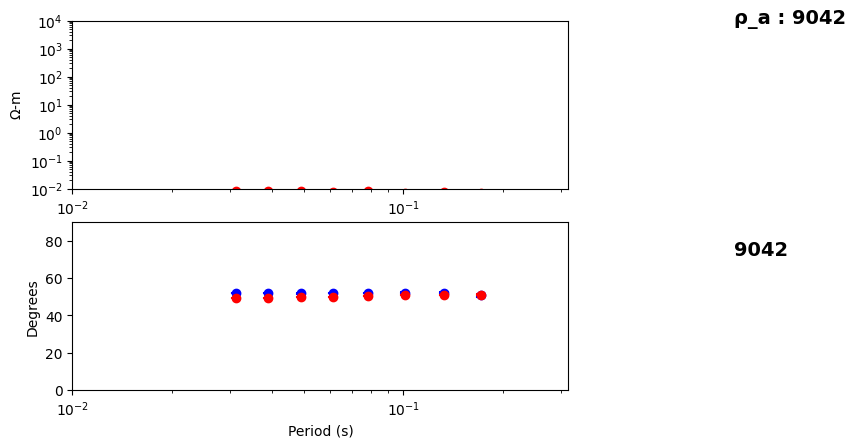

24:10:05T15:45:40 | INFO | line:124 |aurora.pipelines.transfer_function_kernel | update_dataset_df | DECIMATION LEVEL 1
24:10:05T15:45:41 | INFO | line:143 |aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 1 Successfully
24:10:05T15:45:42 | ERROR | line:151 |mth5.groups.filters | to_filter_object | Could not find mtu-5c_rmt03-g_10409_10000hz_low_pass in the filter dictionary
24:10:05T15:45:42 | WARNING | line:261 |mth5.groups.channel_dataset | channel_response | Could not locate filter mtu-5c_rmt03-g_10409_10000hz_low_pass
24:10:05T15:45:42 | ERROR | line:151 |mth5.groups.filters | to_filter_object | Could not find mtu-5c_rmt03-g_10409_10000hz_low_pass in the filter dictionary
24:10:05T15:45:42 | WARNING | line:261 |mth5.groups.channel_dataset | channel_response | Could not locate filter mtu-5c_rmt03-g_10409_10000hz_low_pass
24:10:05T15:45:43 | ERROR | line:151 |mth5.groups.filters | to_filter_object | Could not find mtu-5c_

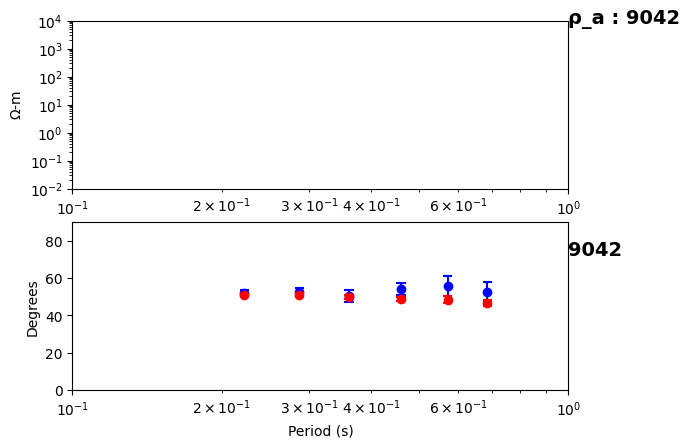

24:10:05T15:45:45 | INFO | line:124 |aurora.pipelines.transfer_function_kernel | update_dataset_df | DECIMATION LEVEL 2
24:10:05T15:45:45 | INFO | line:143 |aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 2 Successfully
24:10:05T15:45:45 | ERROR | line:151 |mth5.groups.filters | to_filter_object | Could not find mtu-5c_rmt03-g_10409_10000hz_low_pass in the filter dictionary
24:10:05T15:45:45 | WARNING | line:261 |mth5.groups.channel_dataset | channel_response | Could not locate filter mtu-5c_rmt03-g_10409_10000hz_low_pass
24:10:05T15:45:45 | ERROR | line:151 |mth5.groups.filters | to_filter_object | Could not find mtu-5c_rmt03-g_10409_10000hz_low_pass in the filter dictionary
24:10:05T15:45:45 | WARNING | line:261 |mth5.groups.channel_dataset | channel_response | Could not locate filter mtu-5c_rmt03-g_10409_10000hz_low_pass
24:10:05T15:45:45 | ERROR | line:151 |mth5.groups.filters | to_filter_object | Could not find mtu-5c_

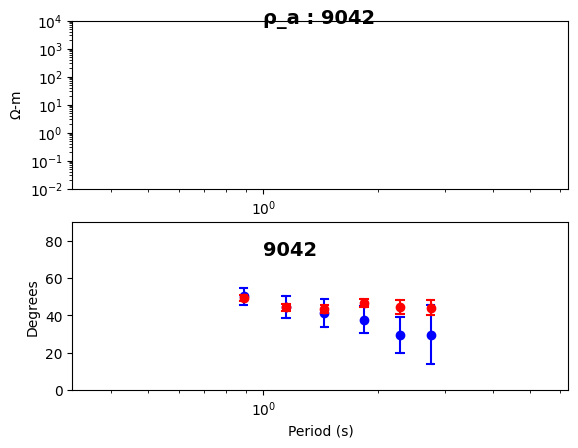

24:10:05T15:45:47 | INFO | line:124 |aurora.pipelines.transfer_function_kernel | update_dataset_df | DECIMATION LEVEL 3
24:10:05T15:45:47 | INFO | line:143 |aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 3 Successfully
24:10:05T15:45:47 | ERROR | line:151 |mth5.groups.filters | to_filter_object | Could not find mtu-5c_rmt03-g_10409_10000hz_low_pass in the filter dictionary
24:10:05T15:45:47 | WARNING | line:261 |mth5.groups.channel_dataset | channel_response | Could not locate filter mtu-5c_rmt03-g_10409_10000hz_low_pass
24:10:05T15:45:47 | ERROR | line:151 |mth5.groups.filters | to_filter_object | Could not find mtu-5c_rmt03-g_10409_10000hz_low_pass in the filter dictionary
24:10:05T15:45:47 | WARNING | line:261 |mth5.groups.channel_dataset | channel_response | Could not locate filter mtu-5c_rmt03-g_10409_10000hz_low_pass
24:10:05T15:45:47 | ERROR | line:151 |mth5.groups.filters | to_filter_object | Could not find mtu-5c_

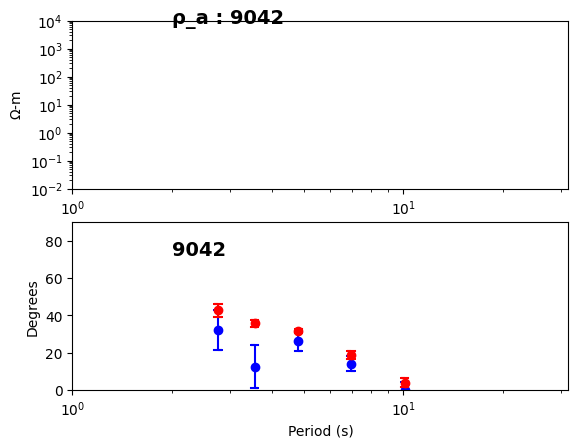

24:10:05T15:45:48 | INFO | line:777 |mth5.mth5 | close_mth5 | Flushing and closing ../../data/time_series/phoenix/mth5_from_phoenix.h5


In [18]:
show_plot = True
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=None,
                )

Not sure what the issue is here, but maybe something to do with the vary large file.

In [2]:
slice_length = 152291328
data_length  = 243284989

A reasonable thing to try is to shorten the time window

In [12]:
kernel_dataset.df.start += pd.Timedelta("12h")  #Snip 6h off the front
kernel_dataset.df.end -= pd.Timedelta("12h")

In [13]:
kernel_dataset.mini_summary

,survey,station_id,run_id,start,end,duration
0,yellowstone,wb280,sr1024_0001,2017-07-02 15:01:00+00:00,2017-07-03 08:19:42+00:00,148722.0
1,yellowstone,wb380,sr1024_0001,2017-07-02 15:01:00+00:00,2017-07-03 08:19:42+00:00,148722.0


In [14]:
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset)

Bands not defined; setting to EMTF BANDS_DEFAULT_FILE
/home/kkappler/software/irismt/aurora/aurora/config/emtf_band_setup/bs_test.cfg
OK


DATASET DF POPULATED
Processing config indicates 4 decimation levels 
DATASET DF UPDATED


2022-10-16 18:26:21,580 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2022-10-16 18:26:21,879 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2022-10-16 18:26:22,150 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2022-10-16 18:27:26,820 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2022-10-16 18:27:27,106 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2022-10-16 18:27:27,363 [line 222] mt_me

Processing band 0.025126s
Processing band 0.019462s
Processing band 0.014809s
Processing band 0.011471s
Processing band 0.008980s
Processing band 0.007190s
Processing band 0.005719s
Processing band 0.004573s


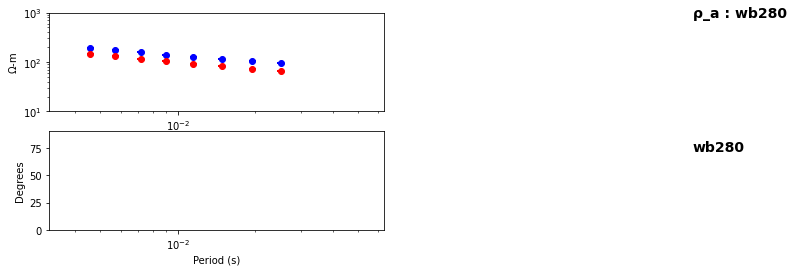

DECIMATION LEVEL 1
DATASET DF UPDATED


2022-10-16 18:46:15,738 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2022-10-16 18:46:15,832 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2022-10-16 18:46:15,932 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2022-10-16 18:46:26,768 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2022-10-16 18:46:26,856 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2022-10-16 18:46:26,944 [line 222] mt_me

Processing band 0.100504s
Processing band 0.083624s
Processing band 0.067267s
Processing band 0.052926s
Processing band 0.041996s
Processing band 0.032530s


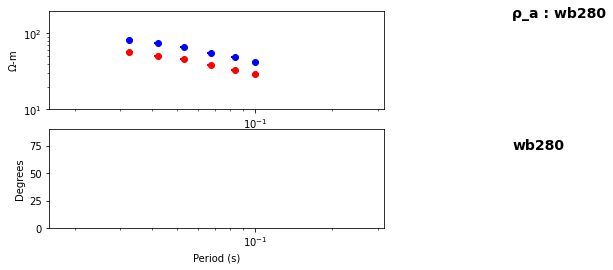

DECIMATION LEVEL 2
DATASET DF UPDATED


2022-10-16 18:48:30,932 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2022-10-16 18:48:30,994 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2022-10-16 18:48:31,056 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2022-10-16 18:48:34,259 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2022-10-16 18:48:34,322 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2022-10-16 18:48:34,393 [line 222] mt_me

Processing band 0.402015s
Processing band 0.334497s
Processing band 0.269069s
Processing band 0.211702s
Processing band 0.167984s
Processing band 0.130120s


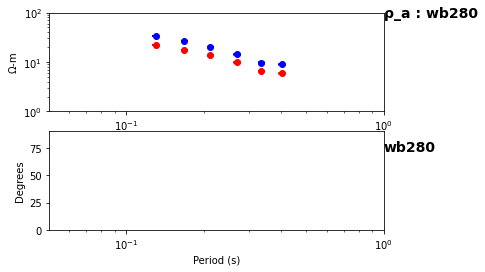

DECIMATION LEVEL 3
DATASET DF UPDATED


2022-10-16 18:49:14,489 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2022-10-16 18:49:14,544 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2022-10-16 18:49:14,599 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2022-10-16 18:49:15,667 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2022-10-16 18:49:15,726 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2022-10-16 18:49:15,837 [line 222] mt_me

Processing band 1.479201s
Processing band 1.018056s
Processing band 0.706417s
Processing band 0.520480s
Processing band 0.403162s


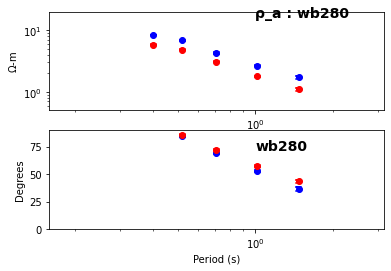

2022-10-16 18:49:32,208 [line 753] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing ../../data/time_series/zen/from_z3d.h5
2022-10-16 18:49:32,283 [line 753] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing ../../data/time_series/zen/from_z3d.h5


In [15]:
show_plot = True
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=None,
                )